# Tour du Mont-Blanc 2016 Analysis

### By Jeremy Tuloup - [@jtpio](https://twitter.com/jtpio)

Blog post: [https://jtp.io/2017/02/12/tmb-2016-analysis.html](https://jtp.io/2017/02/12/tmb-2016-analysis.html)


Facing new challenges is always a good thing. And they can be of any type.

In August 2016, I decided to go hiking around the Mont-Blanc (highest montain in Europe).

**9 days. 3 people. Carrying a tent and using it every day. ~160 km in total.**

I had several goals in mind:

1. For personal reasons, this is something I had wanted to do for about a year
2. Record GPS data and write some kind of report with numbers and graphs
3. Face a new challenge to push my physical limits and motivation further

While I was preparing the Tour du Mont-Blanc (commonly called TMB), it was quite difficult to find good information about the different days. There are **plenty** of blog posts from other trekkers, books and guides with useful advice. That's true. But what I really wanted was a good online resource with the number of kilometers as well as an estimation of the elevation and times for all the different parts of the track. And I couln't find any!

The purpose of this notebook is to **provide this "stats oriented guide"**, and show how convenient it can be to mix programming and data to tell a story.

## Gear

The GPS data was recorded with a standard Android phone (Nexus 5).

Every morning, we would simply start the recording, let the device do its job and stop the recording at the end of the day. Sometimes (although not systemactically), I would place a mark to indicate longer breaks (e.g lunch).

Looking at the graphs below, you will notice disparities in the data, caused by the quality of the sampling. They can be quite annoying, especially when computing summary statistics related to the elevation. But data analysis is also about this: dealing with data that is not necessary clean and well formated.

## Visualizing the data

There are several websites that make it possible to visualize GPS data.

A good one is [mapexplorer.com](http://maplorer.com/view_gpx.html). Upload a GPX file to visualize both the trace map and the elevation graph. Quite useful for single tracks, but not very practical in our case when the goal is to combine several days on the same page.

Thankfully, the Jupyter Notebook makes it quite easy to write text and show photos while plotting data. Super convenient to tell a story!

## Setup

This analysis was based on a fresh Anaconda environment.

In [1]:
import sys
print(sys.version)

3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


Let's define some tools and libraries needed to create the statistics and graphs. We rely on some useful packages:

`pip install seaborn folium gpxpy piexif srtm.py`

In [2]:
import datetime
import folium
import glob
import gpxpy
import matplotlib.pyplot as plt
import os
import pandas as pd
import piexif
import seaborn as sns
import srtm
from collections import defaultdict
from IPython.display import display, HTML
from pytz import timezone
from statistics import mean

%matplotlib inline
plt.rcdefaults()
sns.set_style('darkgrid')
sns.set_palette('deep', desat=.6)
sns.set_context(rc={"figure.figsize": (16, 9)})

# tweak table display
display(HTML('<style>.rendered_html td, .rendered_html th { text-align: center; } table { width: 100%;} </style>'))

france = timezone('Europe/Paris')

`folium` will display the maps, and `gpxpy` load and manipulate gpx data.

`srtm` will help fix the elevation data recorded by the Android device. The raw data is indeed not that good and shows lots of jumps in the elevation.

In [3]:
DATA_FOLDER = './gps_data/'
data_files = [os.path.join(DATA_FOLDER, f) for f in os.listdir(DATA_FOLDER)]

# sort by day
data_files.sort()

# retrieve the elevation data to fix the raw (recorded) elevation
elevation_data = srtm.get_data()

Now, let's build a mini framework that will be reused for each day. Doing so, we can minimize the number of lines of code and focus on the story telling.

To make it simpler, let's load all the data at once.

In [4]:
day_points = []
stats = defaultdict(list)

for file in data_files:
    with open(file, 'r') as f:
        gpx = gpxpy.parse(f)
    
    elevation_data.add_elevations(gpx, smooth=True)
    points = gpx.get_points_data()
    day_points.append({
        'points': points,
        'waypoints': gpx.waypoints
    })
    
    lowest, highest = gpx.get_elevation_extremes()
    uphill, downhill = gpx.get_uphill_downhill()
    stats['Date'].append(gpx.get_time_bounds().start_time)
    stats['Distance'].append(round(points[-1].distance_from_start / 1000, 2))
    stats['Duration'].append(str(datetime.timedelta(seconds=gpx.get_duration())))
    stats['Lowest'].append(int(lowest))
    stats['Highest'].append(int(highest))
    stats['Uphill'].append(int(uphill))
    stats['Downhill'].append(int(downhill))
    
df = pd.DataFrame(
    stats,
    columns=['Date', 'Distance', 'Duration', 'Lowest', 'Highest', 'Uphill', 'Downhill']
)

df.columns = ['Date', 'Distance (km)', 'Duration', 'Lowest (m)', 'Highest (m)', 'Uphill (m)', 'Downhill (m)']
# reindex by date
df['Date'] = df['Date'].map(lambda dt: dt.replace(tzinfo=france))

There is another interesting thing to do with an interactive map: place markers along the trail and show a photo taken at that position (similar to the way Google Maps does it).

This requires having the GPS coordinates for each photo. While most of the smartphones add them automatically in the metadata, this is not the case for my old camera :(

However, **the camera saves the time at which the photo was taken**. To associate a photo with a location, we can go through the list of location and compare the time.

In [5]:
# offset between the camera and the phone (still winter time)
CLOCK_OFFSET = datetime.timedelta(hours=2, minutes=0)

In [6]:
# Serve the images from the web so they are correctly displayed in the folium iframe
BASE_PHOTO_URL = 'https://raw.githubusercontent.com/jtpio/data-playground/master/tmb/'

In [7]:
def plot_photos(m, points, day):
    for img_file in glob.iglob('./photos/{}/*.JPG'.format(day), recursive=True):
        exif_dict = piexif.load(img_file)
        raw_date = exif_dict['0th'][piexif.ImageIFD.DateTime].decode('utf-8')
        d = datetime.datetime.strptime(raw_date, '%Y:%m:%d %H:%M:%S') - CLOCK_OFFSET
        closest_point = min(points, key=lambda p: abs(p.point.time - d)).point
        
        # normalize the pictures size
        width = 600
        resolution_x = exif_dict['Exif'][piexif.ExifIFD.PixelXDimension]
        resolution_y = exif_dict['Exif'][piexif.ExifIFD.PixelYDimension]
        ratio = resolution_x / resolution_y
        height = width / ratio
        
        lat, lng = closest_point.latitude, closest_point.longitude
        img_link = os.path.join(BASE_PHOTO_URL, img_file)
        img_html = '<img src="{}" width={}/>'.format(img_link, width)
        img_frame = folium.element.IFrame(html=img_html, width=width + 20, height=height + 20)
        popup = folium.Popup(img_frame, max_width=width + 20)
        marker = folium.Marker((lat, lng), popup=popup,
                              icon=folium.Icon(color='green', icon='picture'))
        marker.add_to(m)

Then, given a set of points, plot them on a map.

In [8]:
def plot_track(m, points, waypoints, zoom):
    points = [p.point for p in points]
    mean_lat = mean(p.latitude for p in points)
    mean_lng = mean(p.longitude for p in points)
    
    # create the map
    m.location = [mean_lat, mean_lng]
    m.zoom_start = zoom
    
    pts = [(p.latitude, p.longitude) for p in points]
    folium.PolyLine(pts, color='red', weight=2.5, opacity=1).add_to(m)

Given a set of points, plot the elevation over the distance.

In [9]:
def plot_elevation(points, waypoints):
    px = [p.distance_from_start / 1000 for p in points]
    py = [p.point.elevation for p in points]
    plt.plot(px, py)
    plt.xlabel('Distance (km)')
    plt.ylabel('Elevation (m)')
    plt.xlim(0, px[-1])
    plt.show()

Given a day, show its statistics.

In [10]:
def plot_day(day, zoom=13):
    m = folium.Map()
    points = day_points[day - 1]['points']
    wps = day_points[day - 1]['waypoints']
    
    display(HTML(df[day-1:day].to_html(index=False)))
    plot_track(m, points, wps, zoom)
    plot_photos(m, points, day)
    display(m)
    
    plot_elevation(points, wps)

Plot all the days.

In [11]:
def plot_all_days(zoom=13):
    points = [pt for pts in day_points for pt in pts['points']]
    m = folium.Map()
    plot_track(m, points, [], zoom)
    display(m)

All set. Time for the trip!

## Day 1: Les Houches - Chalets de Miage

Date,Distance (km),Duration,Lowest (m),Highest (m),Uphill (m),Downhill (m)
2016-08-01 08:11:29+02:00,15.29,5:53:51,988,2114,1356,776


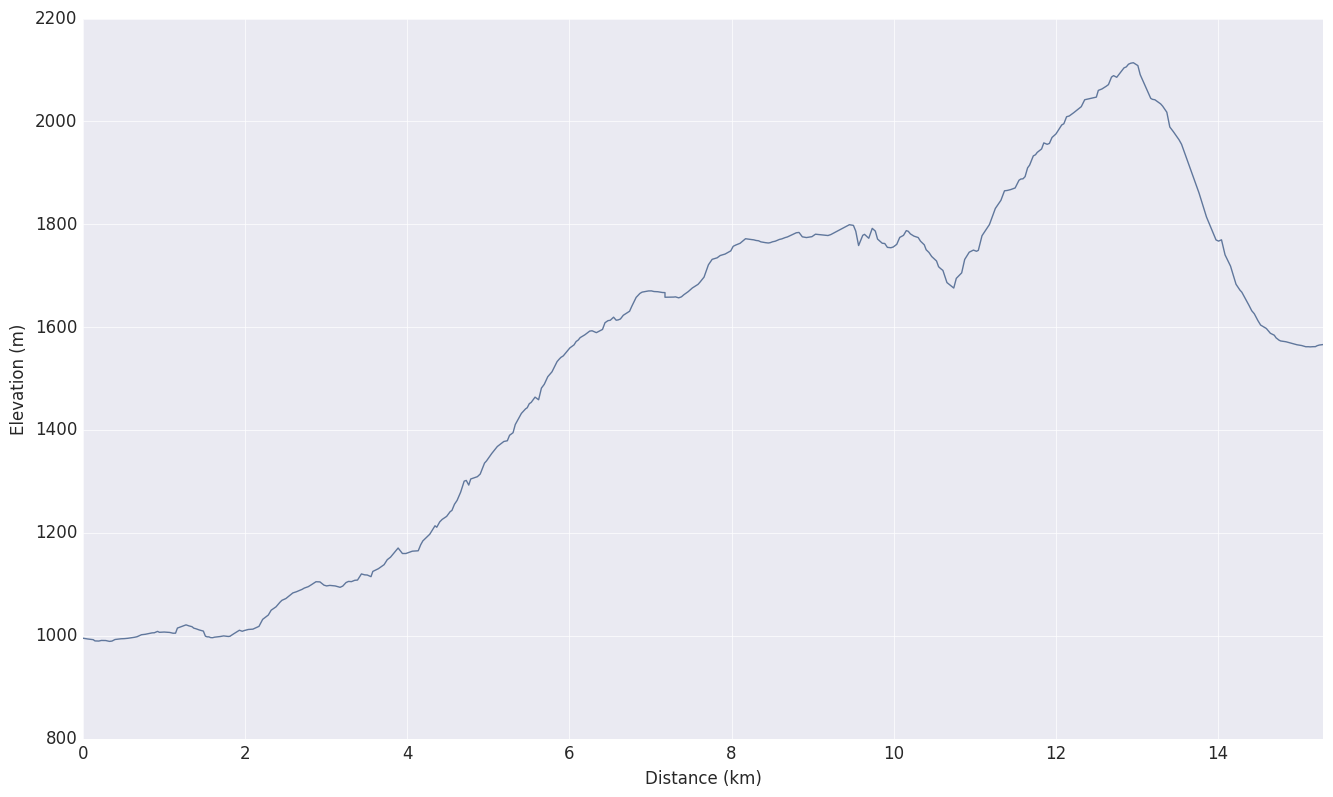

In [12]:
plot_day(1)

Quite challenging for a first day!

We started with the rain. Damn, that wasn't really convincing. Good for a first motivation test though. Fortunately the weather became way better a few hours later and sunny the entire afternoon.

Pretty steep start, going huphill until Col de la Voza. We continued our way up to reach the Col du Tricot, followed by a quite abrupt way down to Chalets de Miage.

## Day 2: Chalets de Miage - Refuge du Col de la Croix du Bonhomme

Date,Distance (km),Duration,Lowest (m),Highest (m),Uphill (m),Downhill (m)
2016-08-02 06:50:55+02:00,20.03,8:19:05,1146,2485,1567,683


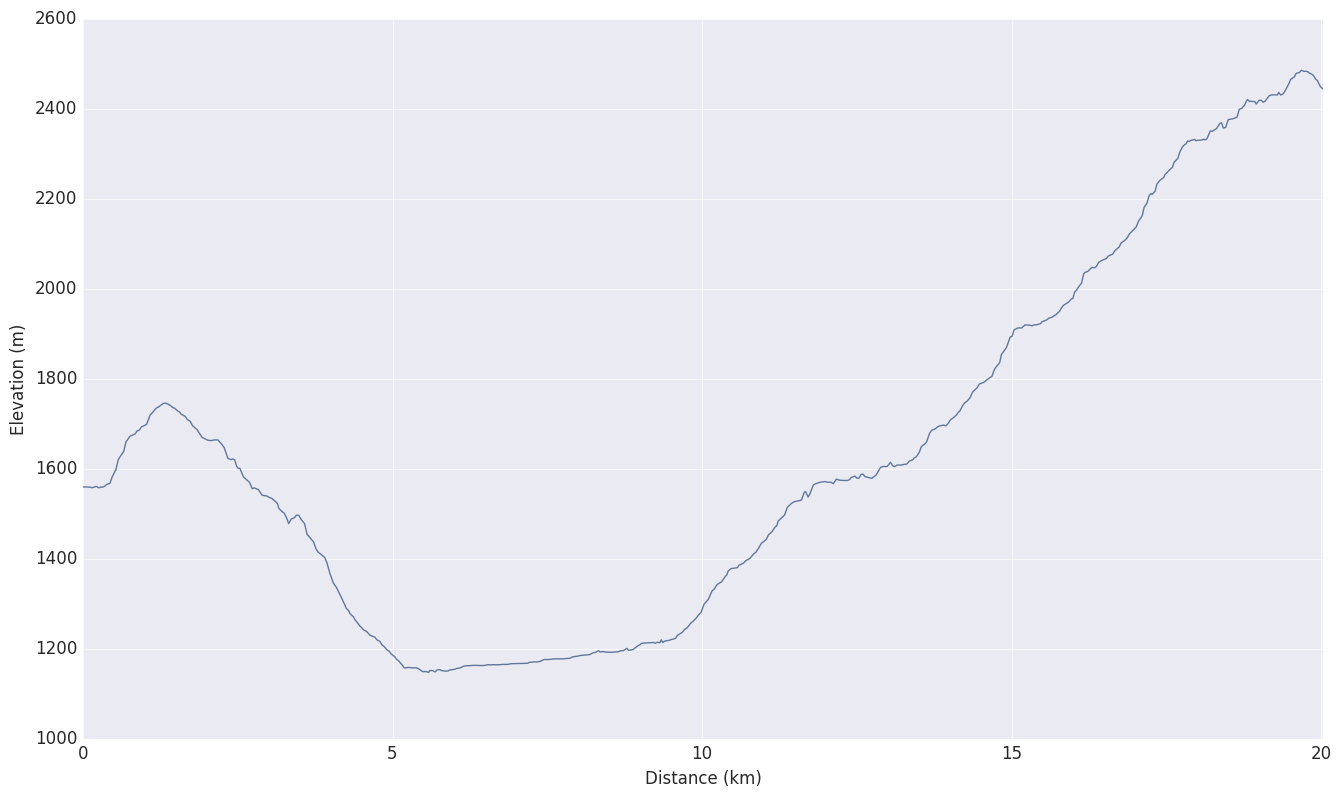

In [13]:
plot_day(2, zoom=12)

The second day was probably one of the most difficult of the entire trip:

- It was the second day only, still a long way to go until the end
- First pain in the back and on the shoulders due to the heavy backpacks (even though it was quite expected)
- Long distance and high elevation difference

In the morning, we passed though the small village of Les Contamines-Montjoie. Perfect timing to pick up fresh fruits at the market.

It was also a good opportunity to have a look at the elegant Notre Dame de la Gorge church.

Arriving at Refuge du Col de la Croix du Bonhomme (loooooong name), we were pleased to find a herd of mountain goats on the creast. Since it was the end of the day, it gave a nice silhouette effect.

![Mountain goats](https://raw.githubusercontent.com/jtpio/data-playground/master/tmb/photos/2/goats.jpg)

## Day 3: Refuge du Col de la Croix du Bonhomme - Lac du Miage

Date,Distance (km),Duration,Lowest (m),Highest (m),Uphill (m),Downhill (m)
2016-08-03 06:48:53+02:00,21.38,12:00:35,1783,2662,1085,1511


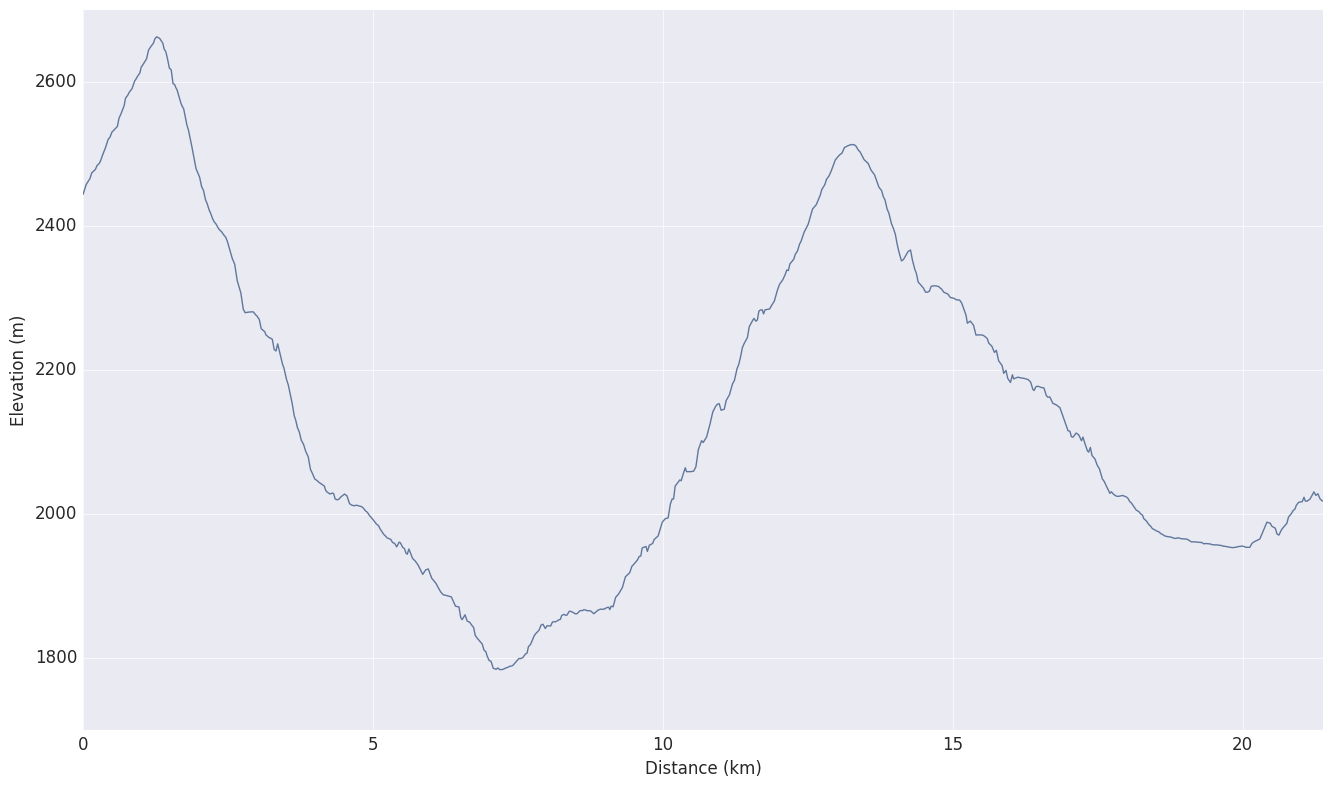

In [14]:
plot_day(3, zoom=12)

Day 3 was another long day, full of surprises with its variety of landscapes. The valley from Col de la Seigne to Lac du Miage was quite daunting: such a big opening in the middle of the mountains.

At first, we thought we could find a nice spot for the night around the Lac de Combal. It turns out it's more a swamp than a lake!

We pushed the hike a little bit further to Lac du Miage to find a very sweet camping spot. We could also take a (refreshing) bath in this lake, quick but very appreciated.

## Day 4: Lac du Miage - Camping "La Sorgente" (Courmayeur)

Date,Distance (km),Duration,Lowest (m),Highest (m),Uphill (m),Downhill (m)
2016-08-04 08:15:36+02:00,15.39,9:45:39,1207,1999,177,959


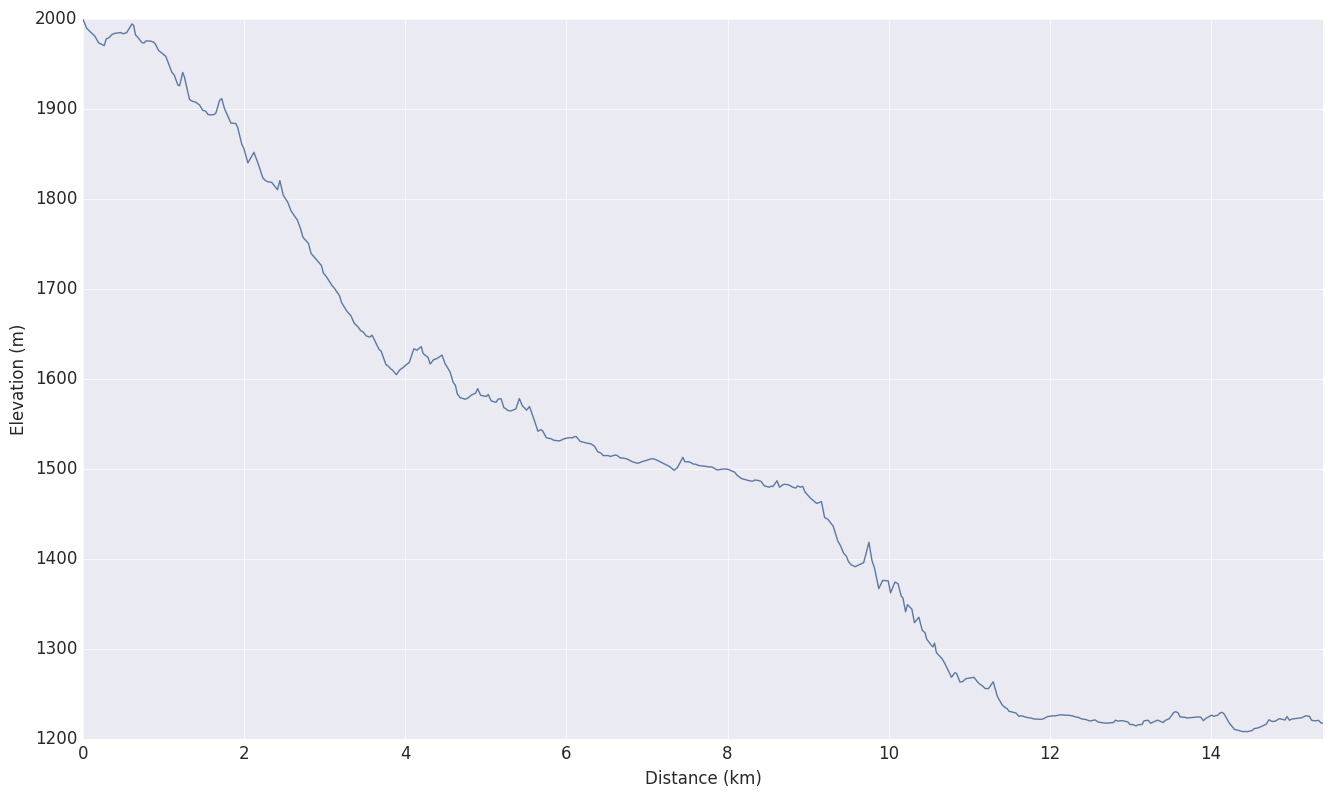

In [15]:
plot_day(4)

A day with less than 200 m uphill. How unusual this is!

Following the two previous demanding days, we decided it would be wise to take it easy for day 4.

We first hiked down to a proper camp site, Camping "La Sorgente". Comfort and shower helped us recharge batteries. We then decided to walk down to Courmayeur and visit the city. At the end of the day, we went back to the camp site by bus before the storm.

## Day 5: Courmayeur - Chalet Val Ferret

Date,Distance (km),Duration,Lowest (m),Highest (m),Uphill (m),Downhill (m)
2016-08-05 08:13:52+02:00,17.38,8:05:56,1262,2043,1285,793


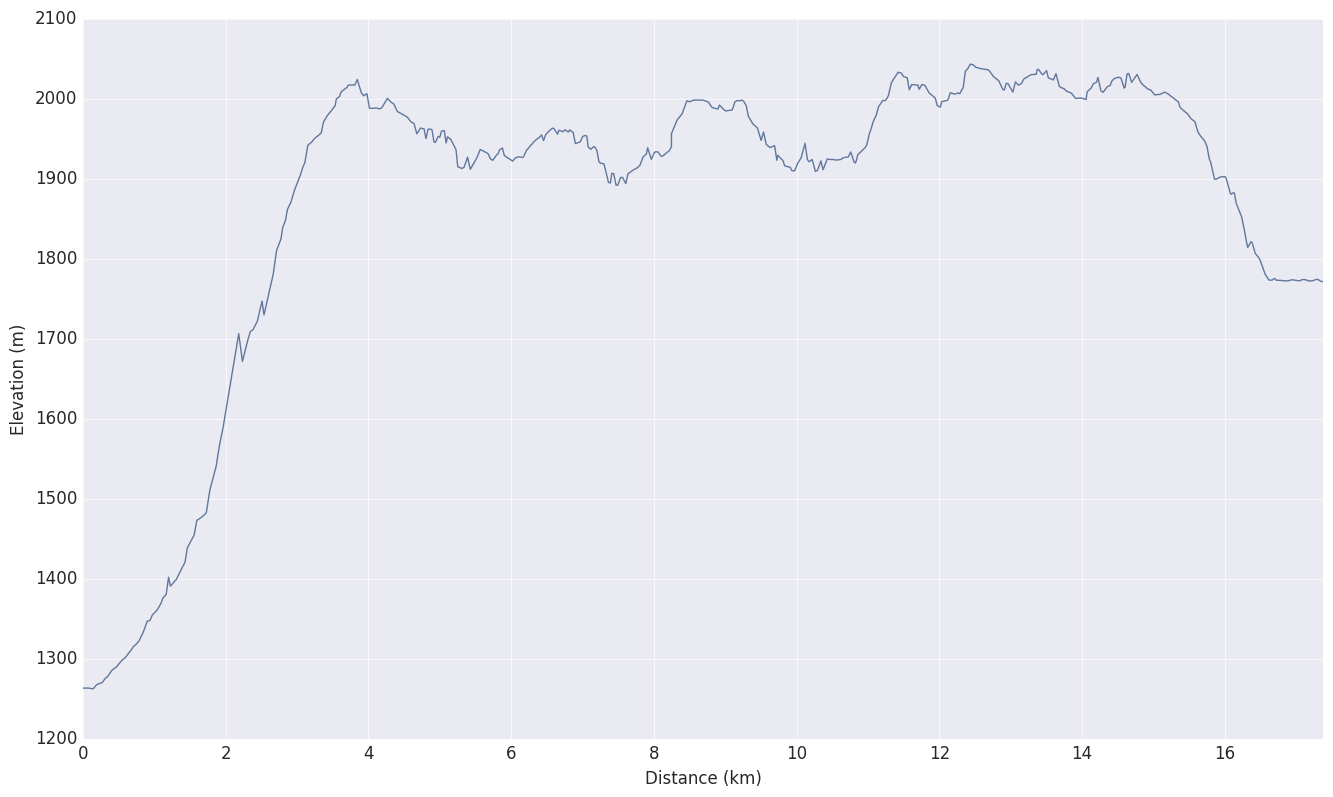

In [16]:
plot_day(5, zoom=12)

Our first rainy day :(

We took the bus down from Camping "La Sorgente" to Courmayeur, since we already walked this part the day before.

We knew we would have at least a day of rain during the entire trip. Even though the elevation chart looks quite flat, the rain made the paths very slippery and muddy. Full focus required, especially for the way down at the end of the day.

We stopped next to the Chalet Val Ferret, and spent the evening eating warm food and play cards. Our first goal was to reach the Refuge Elena, but in retrospect it was so much wiser to stop a bit before (Refuge Elena is very exposed to the wind).

## Day 6: Chalet Val Ferret - Champex-Lac

Date,Distance (km),Duration,Lowest (m),Highest (m),Uphill (m),Downhill (m)
2016-08-06 08:22:57+02:00,14.99,6:38:24,1440,2534,683,1018


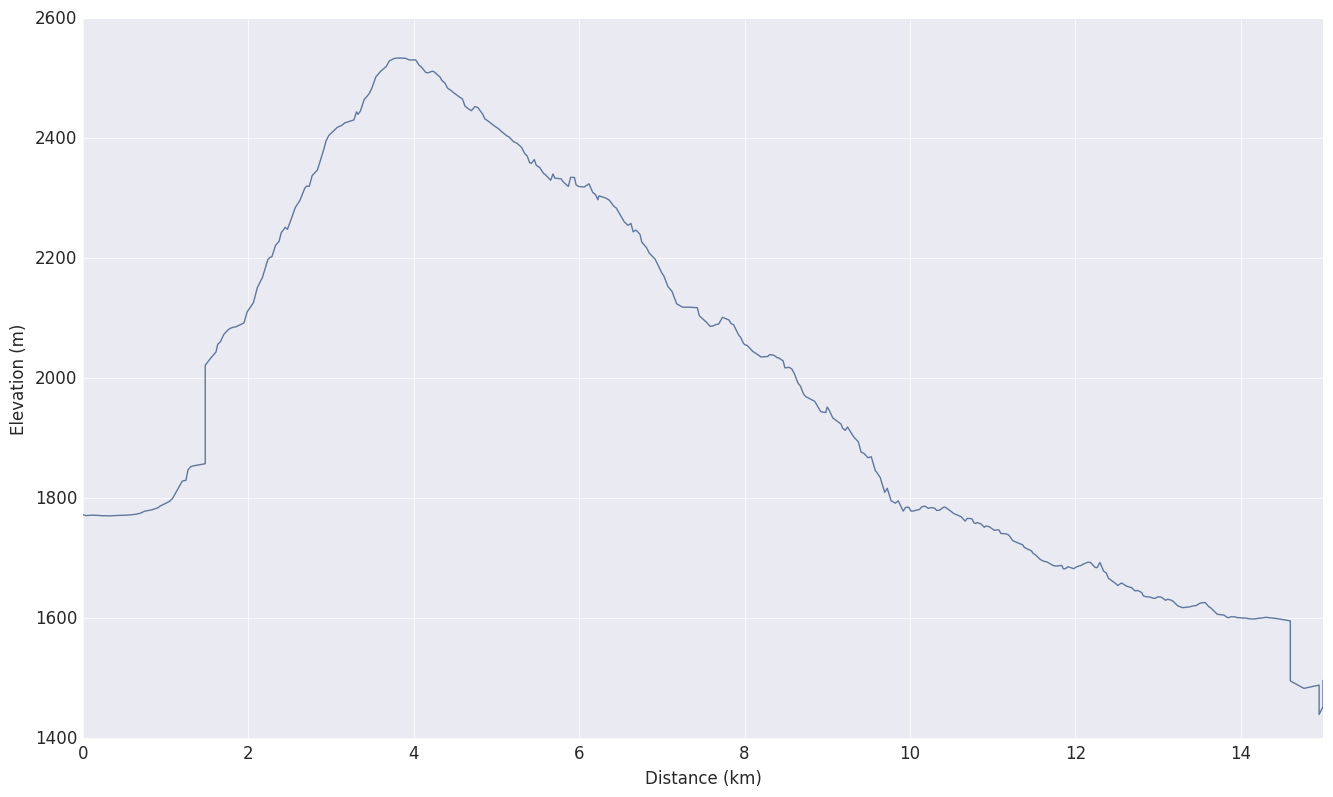

In [17]:
plot_day(6)

Another day, another country.

Time to go to Switzerland. We first passed next to Refuge Elena, then the Grand Col Ferret. It was super windy up there.

We made our way down to La Fleury and took the bus directly to Champex-Lac (notice the vertical drop on the graph, the recording was stopped).

Why the bus? This is something we had planned beforehand to be able to do the tour in 9 days. It saved us many kilometers and time. Plus, this portion of the trip looked a bit less interesting (as mentioned in other blog posts).

## Day 7: Champex-Lac - Col de la Forclaz

Date,Distance (km),Duration,Lowest (m),Highest (m),Uphill (m),Downhill (m)
2016-08-07 07:33:03+02:00,15.18,8:34:34,1492,2557,1411,1371


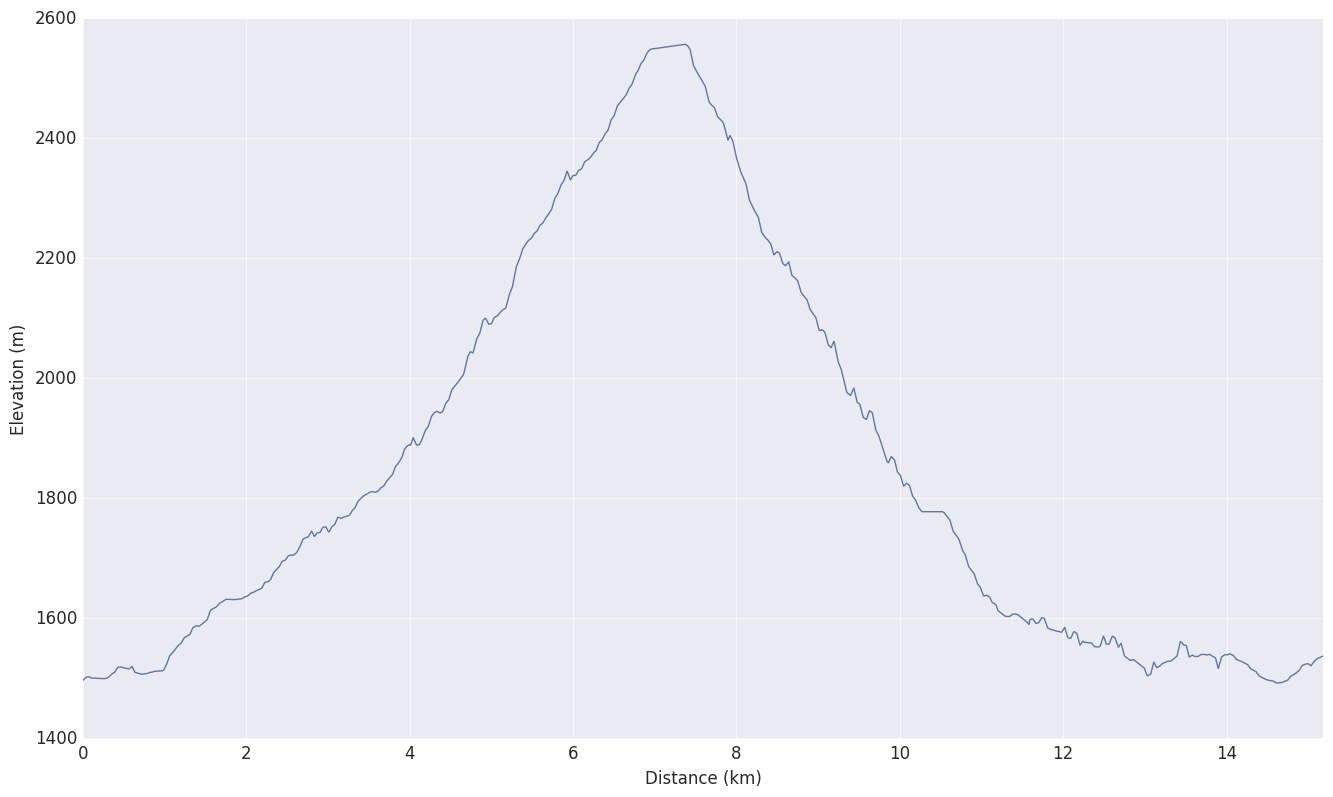

In [18]:
plot_day(7)

Starting from Champex-Lac, we could choose to go either with the normal route, or with a variant.

We went for the variant (more challenge = more fun!), and were not disappointed at all.

This brought us to Fenêtre d'Arpette, one of the highest points of the Tour du Mont Blanc. The weather was beautiful and the view from the top amazing. Totally worth it.

The way down to Col de la Forclaz was however rather long and repetitive. Bad for the knees once again!

## Day 8: Col de la Forclaz - Argentière

Date,Distance (km),Duration,Lowest (m),Highest (m),Uphill (m),Downhill (m)
2016-08-08 07:59:23+02:00,18.04,7:39:47,1219,2198,1193,1257


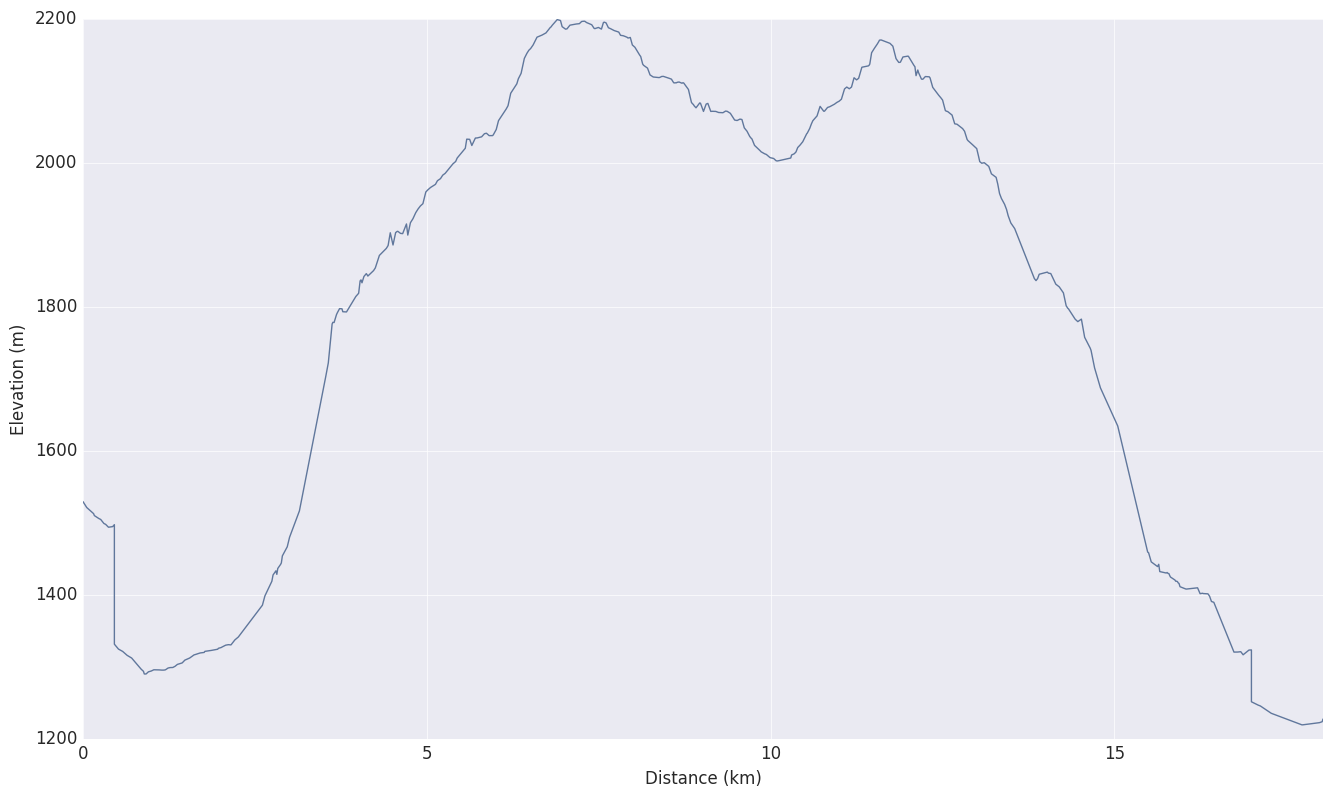

In [19]:
plot_day(8, zoom=12)

As we were approaching the end of the trip, we were more and more customizing the trip depending on our needs and physical conditions.

We really wanted to have a look at the Lac Blanc the day after, but it wasn't a realistic goal unfortunately. Plus we learned that the weather would be quite unpleasant (rain), which made us stop in Argentiere and skip the Lac Blanc.

The elevation graph shows a few vertical lines, due to GPS signal loss.

## Day 9: Argentière - Chamonix

Date,Distance (km),Duration,Lowest (m),Highest (m),Uphill (m),Downhill (m)
2016-08-09 08:19:04+02:00,13.98,6:16:44,1046,1876,1048,1223


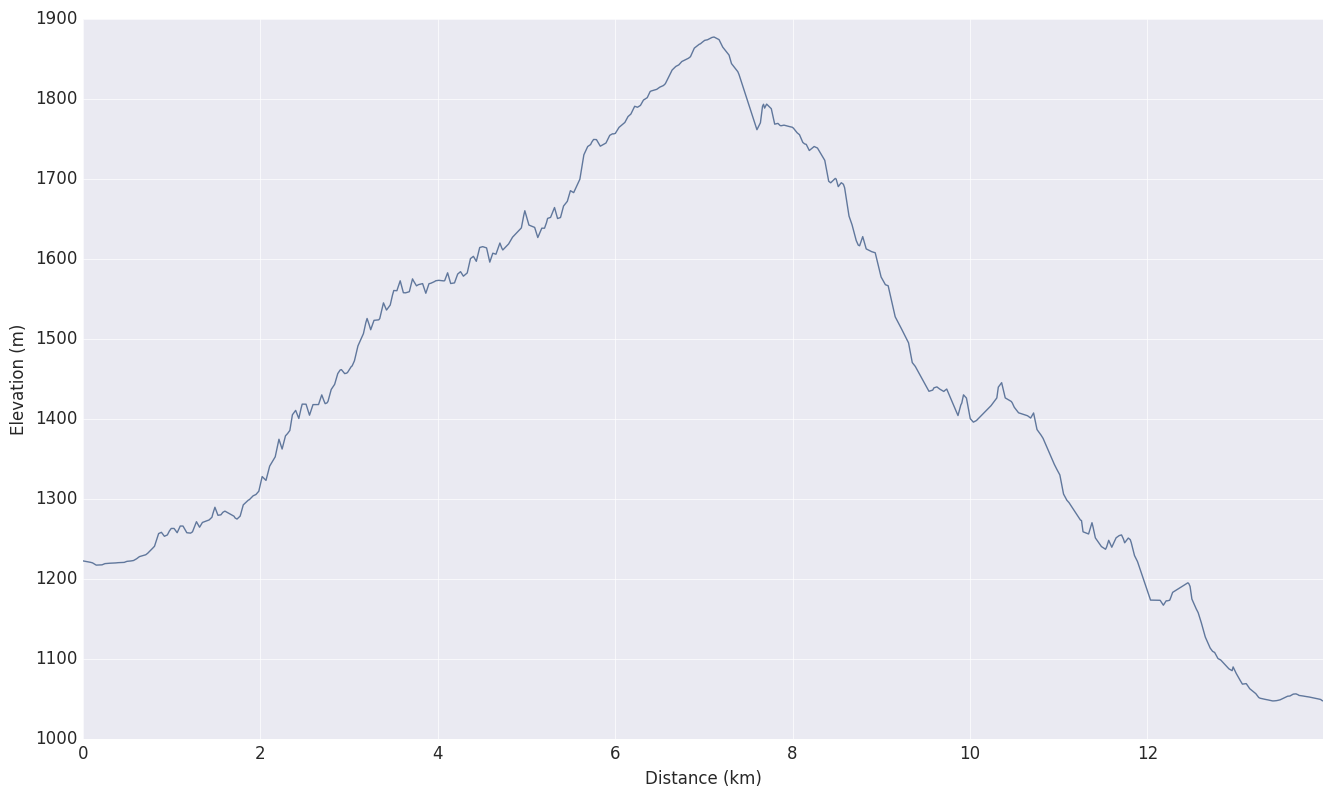

In [20]:
plot_day(9)

Last day of the trip. We decided to finish in Chamonix instead of Les Houches. I have to say it's not the complete loop, but we had time constraints to respect (9 days) and chosed the saner option!

## All In

After detailing every day one by one, it's time for the recap!

In [21]:
HTML(df.to_html(index=False))

Date,Distance (km),Duration,Lowest (m),Highest (m),Uphill (m),Downhill (m)
2016-08-01 08:11:29+02:00,15.29,5:53:51,988,2114,1356,776
2016-08-02 06:50:55+02:00,20.03,8:19:05,1146,2485,1567,683
2016-08-03 06:48:53+02:00,21.38,12:00:35,1783,2662,1085,1511
2016-08-04 08:15:36+02:00,15.39,9:45:39,1207,1999,177,959
2016-08-05 08:13:52+02:00,17.38,8:05:56,1262,2043,1285,793
2016-08-06 08:22:57+02:00,14.99,6:38:24,1440,2534,683,1018
2016-08-07 07:33:03+02:00,15.18,8:34:34,1492,2557,1411,1371
2016-08-08 07:59:23+02:00,18.04,7:39:47,1219,2198,1193,1257
2016-08-09 08:19:04+02:00,13.98,6:16:44,1046,1876,1048,1223


In [22]:
total_distance = round(df['Distance (km)'].sum(), 2)
total_uphill = round(df['Uphill (m)'].sum() / 1000, 2)
total_downhill = round(df['Downhill (m)'].sum() / 1000, 2)

# put in a dataframe to keep the same look (table)
df_total = pd.DataFrame([[total_distance, total_uphill, total_downhill]])
df_total.columns = ['Total Distance (km)', 'Total uphill (km)', 'Total downhill (km)']

HTML(df_total.to_html(index=False))

Total Distance (km),Total uphill (km),Total downhill (km)
151.66,9.8,9.59


First things first: our initial estimation of 160 km was pretty good!

Second: the total uphill and downill almost match, which is comforting since we started and ended at about the same altitude. The little difference (200 m) can be due to the signal losses and the fact that Les Houches is a little bit lower than Chamonix.

During this analysis, many steps had to be taken to clean and smooth the data. In this situation, one can even push further and try using [Kalman Filters](https://en.wikipedia.org/wiki/Kalman_filter). This approach is mentioned in a presentation called [Handling GPS data with Python](https://nbviewer.jupyter.org/format/slides/github/FlorianWilhelm/gps_data_with_python/blob/master/talk.ipynb#/). In theory it would be the right thing to do to improve the quality of the data. But I decided to not go down that road, as it would add more clutter to the (already long enough) post.

Leaving aside the elevation for a while, we can finally plot the entire trace on the map:

In [23]:
plot_all_days(zoom=10)

The little gap between Chamonix and Les Houches now becomes quite apparent.

Apart from that, there it is, our custom Tour du Mont-Blanc trip!

## Final words

Again, Jupyter notebooks came handy. Combining the narration of the trip with statistics for each day is very easy to do with a notebook.

I hope this will help some trekkers organizing their Tour du Mont Blanc. It's a great experience, highly recommended!

The approach used in this notebook can also be adapted to other trips or hikes of course.

And if you are tired of numbers and want more details about other things (camp sites, how to prepare and so on), feel free to ask in the comments below!

Happy trekking and coding :)